# Coastal Endurance Oregon Shelf Surface Mooring Data Quality Report
## Instrument: Single Point Velocity Meter

Evaluation Date: 5/25/2018

Evaluator: Binbin Wang

Review Summary:

This report summarizes a data quality review of the Coastal Endurance Oregon Shelf Surface Mooring Data (CE02SHSM). I foucs on the data of the instrument - Single Point Velocity Meter (04-VELPTA000) on the node at 1 m (SBD11). The data selcted in this report is 8/15/2017-9/15/2018. This report is not necessarily a comprehensive review of the instruments and quality of the data available. Rather, it demonstrates some steps for understanding the data during this period. 

The velocity data was cross-compared with several other snesors on the same platform, including a second single point velocity meter (04-VELPTA000) on the node at 7 m (RID26), a surface wave spectra sensor (05-WAVSSA000) on the surface buoy (SBD12), and the Bulk Meteorology Instrument Package (METBKA) on the surface buoy (SBD11). 

The following array shows the reference designators of surface buoy, note, instrument, method, and stream. 

  ['CE02SHSM','SBD11','04-VELPTA000','recovered_inst','velpt_ab_instrument_recovered']
  
  ['CE02SHSM','RID26','04-VELPTA000','recovered_inst','velpt_ab_instrument_recovered']
  
  ['CE02SHSM','SBD12','05-WAVSSA000','recovered_host','wavss_a_dcl_statistics_recovered']
  
  ['CE02SHSM','SBD11','06-METBKA000','recovered_host','metbk_a_dcl_instrument_recovered']

## Install libraries, import packages. 

In [ ]:
# !pip install xarray
# !pip install netcdf4
# !pip install bokeh
# !pip install dask
import requests
import time
import numpy as np
import re
import xarray as xr
import pandas as pd
import os
import datetime

In [2]:
username = 'OOIAPI-BXYSDAG8AO0MQP'
token = 'T6LUGZGOUMZEVT'

In [3]:
base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

In [4]:
# Time Processing Routines 
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)

In [5]:
r = requests.get(base_url, auth=(username, token))
print( r.status_code )
print( r.headers )
print( r.encoding )
print( r.text )
print( r.json() )

200
{'Server': 'nginx', 'Date': 'Fri, 25 May 2018 13:12:10 GMT', 'Content-Type': 'text/html; charset=utf-8', 'Transfer-Encoding': 'chunked', 'Strict-Transport-Security': 'max-age=63072000; includeSubdomains; ', 'X-Frame-Options': 'SAMEORIGIN', 'X-XSS-Protection': '1; mode=block', 'Content-Encoding': 'gzip'}
utf-8
[ "CE01ISSM", "CE01ISSP", "CE02SHBP", "CE02SHSM", "CE02SHSP", "CE04OSBP", "CE04OSPD", "CE04OSPI", "CE04OSPS", "CE04OSSM", "CE05MOAS", "CE06ISSM", "CE06ISSP", "CE07SHSM", "CE07SHSP", "CE09OSPM", "CE09OSSM", "CP01CNPM", "CP01CNSM", "CP01CNSP", "CP02PMCI", "CP02PMCO", "CP02PMUI", "CP02PMUO", "CP03ISPM", "CP03ISSM", "CP03ISSP", "CP04OSPM", "CP04OSSM", "CP05MOAS", "GA01SUMO", "GA02HYPM", "GA03FLMA", "GA03FLMB", "GA05MOAS", "GI01SUMO", "GI02HYPM", "GI03FLMA", "GI03FLMB", "GI05MOAS", "GP02HYPM", "GP03FLMA", "GP03FLMB", "GP05MOAS", "GS01SUMO", "GS02HYPM", "GS03FLMA", "GS03FLMB", "GS05MOAS", "RS01OSBP", "RS01SBPS", "RS01SHBP", "RS01SHDR", "RS01SLBS", "RS01SUM1", "RS01SUM2", "RS03ASHS",

In [6]:
# A quick function to make an API request and print the results
def get_and_print_api(url):
  r = requests.get(url, auth=(username, token))
  data = r.json()
  for d in data:
    print( d )

In [7]:
# List all nodes on the platform
get_and_print_api(base_url+'/CE02SHSM')

RIC21
RID26
RID27
SBC11
SBD11
SBD12


In [8]:
# List all instrument on the node
get_and_print_api(base_url+'/CE02SHSM/SBD11')

00-DCLENG000
01-MOPAK0000
02-HYDGN0000
04-VELPTA000
06-METBKA000


In [9]:
# List all methods
(base_url+'/CE02SHSM/SBD11/04-VELPTA000')

'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv//CE02SHSM/SBD11/04-VELPTA000'

In [10]:
# List all streams
get_and_print_api(base_url+'/CE02SHSM/SBD11/04-VELPTA000/recovered_inst')

velpt_ab_diagnostics_metadata_recovered
velpt_ab_diagnostics_recovered
velpt_ab_instrument_metadata_recovered
velpt_ab_instrument_recovered


In [11]:
# Look at the velocity sensor 
subsite = 'CE02SHSM'
node = 'SBD11'
sensor = '04-VELPTA000'
method = 'recovered_inst'
stream = 'velpt_ab_instrument_recovered'
beginDT = '2017-08-15T01:00:00.000Z' 
endDT = '2017-09-01T01:00:00.000Z'

In [12]:
data_request_url ='/'.join((base_url,subsite,node,sensor,method,stream))
params = {
    'beginDT':beginDT,
    'endDT':endDT,   
}
r = requests.get(data_request_url, params=params, auth=(username, token))
data = r.json()

In [13]:
data['allURLs'][0]

'https://opendap.oceanobservatories.org/thredds/catalog/ooi/bwang314@tamu.edu/20180525T131224-CE02SHSM-SBD11-04-VELPTA000-recovered_inst-velpt_ab_instrument_recovered/catalog.html'

In [14]:
%%time
check_complete = data['allURLs'][1] + '/status.txt'
for i in range(1800): 
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
        time.sleep(1)

request completed
CPU times: user 724 ms, sys: 58.3 ms, total: 783 ms
Wall time: 1min


In [15]:
url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/bwang314@tamu.edu/20180522T213146-CE02SHSM-SBD11-04-VELPTA000-recovered_inst-velpt_ab_instrument_recovered/catalog.html'
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/bwang314@tamu.edu/20180522T213146-CE02SHSM-SBD11-04-VELPTA000-recovered_inst-velpt_ab_instrument_recovered/deployment0005_CE02SHSM-SBD11-04-VELPTA000-recovered_inst-velpt_ab_instrument_recovered_20170801T010000-20170901T010000.nc']

In [16]:
# ds = xr.open_mfdataset(datasets)
# ds = ds.swap_dims({'obs': 'time'})
# ds = ds.chunk({'time': 100})
# ds = ds.sortby('time') # data from different deployments can overlap so we want to sort all data by time stamp.
# ds

In [17]:
# df = ds.to_dataframe()
# res = (pd.Series(df.index[1:]) - pd.Series(df.index[:-1])).value_counts()
# res

In [18]:
import matplotlib.pyplot as plt

/Users/bwang/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [19]:
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=False)
# fig.set_size_inches(16, 6)

# ds['eastward_velocity'].plot(linestyle = '-', 
#                                    marker='.', 
#                                    markersize=1,
#                                    ax=ax1)

# ds['northward_velocity'].plot(linestyle = '-', 
#                                    marker='.', 
#                                    markersize=1,
#                                    ax=ax2)
# ds['upward_velocity'].plot(linestyle = '-', 
#                                    marker='.', 
#                                    markersize=1,
#                                    ax=ax3)
# ds['pressure_mbar'].plot(linestyle = '-', 
#                                    marker='.', 
#                                    markersize=1,
#                                    ax=ax4)
# # ax.invert_yaxis()

# plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
# plt.show()

## Download data

In [20]:
# Looking at multiple instruments on the buoy
instruments = [
  ['CE02SHSM','SBD11','04-VELPTA000','recovered_inst','velpt_ab_instrument_recovered'],
  ['CE02SHSM','RID26','04-VELPTA000','recovered_inst','velpt_ab_instrument_recovered'],
  ['CE02SHSM','SBD12','05-WAVSSA000','recovered_host','wavss_a_dcl_statistics_recovered'],
  ['CE02SHSM','SBD11','06-METBKA000','recovered_host','metbk_a_dcl_instrument_recovered']
]

In [21]:
# Specify additional parameters for the API request 
params = {
  'beginDT':'2017-08-15T01:00:00.000Z', 
  'endDT':'2017-09-15T01:00:00.000Z'  
}

In [22]:
# Grab the data for each instrument
out = []
for jj in range(len(instruments)):
  print(jj)
  print instruments[jj]  
  data_request_url ='/'.join((base_url,instruments[jj][0],instruments[jj][1],instruments[jj][2],instruments[jj][3],instruments[jj][4]))
  r = requests.get(data_request_url, params=params, auth=(username, token))
  data = r.json()
  out.append(data['allURLs'][0])


SyntaxError: Missing parentheses in call to 'print'. Did you mean print(t instruments[jj])? (<ipython-input-22-26caea62903f>, line 5)

In [ ]:
out

In [ ]:
import xarray as xr

In [23]:
files = [
    'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/bwang314@tamu.edu/20180523T190702-CE02SHSM-SBD11-04-VELPTA000-recovered_inst-velpt_ab_instrument_recovered/deployment0005_CE02SHSM-SBD11-04-VELPTA000-recovered_inst-velpt_ab_instrument_recovered_20170815T010000-20170915T010000.nc',
    'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/bwang314@tamu.edu/20180523T190708-CE02SHSM-RID26-04-VELPTA000-recovered_inst-velpt_ab_instrument_recovered/deployment0005_CE02SHSM-RID26-04-VELPTA000-recovered_inst-velpt_ab_instrument_recovered_20170815T010000-20170915T010000.nc',
    'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/bwang314@tamu.edu/20180523T190720-CE02SHSM-SBD12-05-WAVSSA000-recovered_host-wavss_a_dcl_statistics_recovered/deployment0005_CE02SHSM-SBD12-05-WAVSSA000-recovered_host-wavss_a_dcl_statistics_recovered_20170815T012301.726000-20170915T002303.057000.nc',
    'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/bwang314@tamu.edu/20180524T145145-CE02SHSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0005_CE02SHSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered_20170815T010013.881000-20170915T005911.468000.nc'
]

## Assign data variables

In [24]:
# single point velocity meter at 1 m
d1 = xr.open_dataset(files[0])
time_vel_1m = d1['time'].values
pressure_1m = d1['pressure_mbar'].values/1000.
east_vel_1m = d1['eastward_velocity'].values
north_vel_1m = d1['northward_velocity'].values
up_vel_1m = d1['upward_velocity'].values
heading_1m = d1['heading_decidegree'].values
pitch_1m = d1['pitch_decidegree'].values
roll_1m = d1['roll_decidegree'].values
temp_1m = d1['temperature_centidegree'].values/100.
ampB1_1m = d1['amplitude_beam1'].values
ampB2_1m = d1['amplitude_beam2'].values
ampB3_1m = d1['amplitude_beam3'].values
velocity_beam1 = d1['velocity_beam1'].values
velocity_beam2 = d1['velocity_beam2'].values
velocity_beam3 = d1['velocity_beam3'].values


In [25]:
# single point velocity meter at 7 m
d2 = xr.open_dataset(files[1])
time_vel_7m = d2['time'].values
pressure_7m = d2['pressure_mbar'].values/1000.
east_vel_7m = d2['eastward_velocity'].values
north_vel_7m = d2['northward_velocity'].values
up_vel_7m = d2['upward_velocity'].values
heading_7m = d2['heading_decidegree'].values
pitch_7m = d2['pitch_decidegree'].values
roll_7m = d2['roll_decidegree'].values
temp_7m = d2['temperature_centidegree'].values/100.
ampB1_7m = d2['amplitude_beam1'].values
ampB2_7m = d2['amplitude_beam2'].values
ampB3_7m = d2['amplitude_beam3'].values
velocity_beam1_7m = d2['velocity_beam1'].values
velocity_beam2_7m = d2['velocity_beam2'].values
velocity_beam3_7m = d2['velocity_beam3'].values


In [26]:
# wave statistics at recorded on the buoy
d3 = xr.open_dataset(files[2])
time_wave = d3['time'].values
wave_height = d3['significant_wave_height'].values


In [27]:
# Met data on the buoy
d4 = xr.open_dataset(files[3])
time_met = d4['time'].values
air_temp = d4['air_temperature'].values
sst = d4['sea_surface_temperature'].values
ssc = d4['sea_surface_conductivity'].values
precip = d4['precipitation'].values
wind_e = d4['eastward_wind_velocity'].values
wind_n = d4['eastward_wind_velocity'].values
wind = np.sqrt(wind_e * wind_e + wind_n * wind_n)

## Examine the data

### Plot veloicty data

Text(0,0.5,'up vel (m/s)')

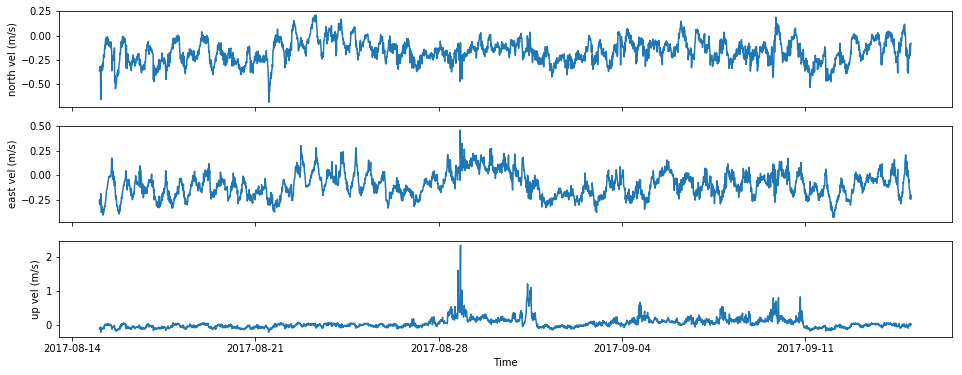

In [28]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True,figsize=(16,6))
ax1.plot(time_vel_1m,north_vel_1m)
ax2.plot(time_vel_1m,east_vel_1m)
ax3.plot(time_vel_1m,up_vel_1m)
plt.xlabel('Time')
ax1.set_ylabel('north vel (m/s)')
ax2.set_ylabel('east vel (m/s)')
ax3.set_ylabel('up vel (m/s)')

Multiple spikes show up in the upward veloicty data after 08/28/2017 and disappear after 09/11/2017. This report will investigate these data. 

### Examine the Beam amplitude counts

Text(0,0.5,'Beam 3 vel (m/s)')

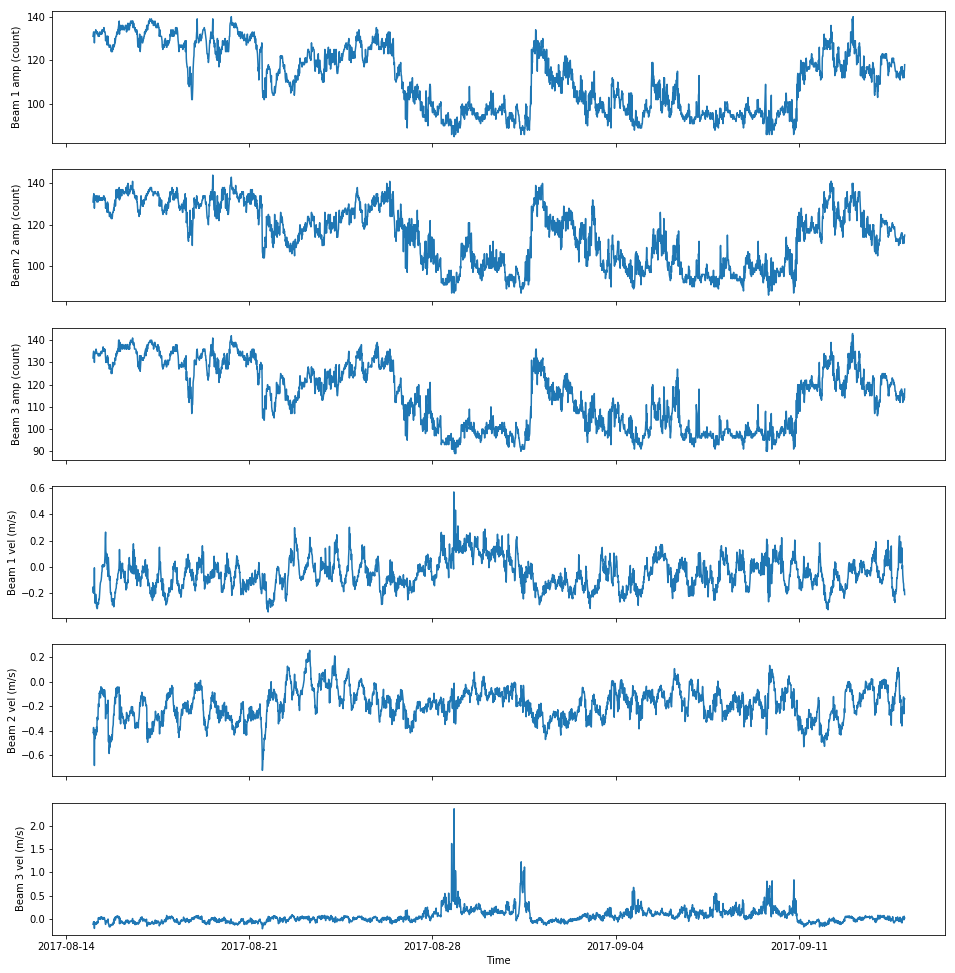

In [29]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(6,1, sharex=True,figsize=(16,17))
ax1.plot(time_vel_1m,ampB1_1m)
ax2.plot(time_vel_1m,ampB2_1m)
ax3.plot(time_vel_1m,ampB3_1m)
ax4.plot(time_vel_1m,velocity_beam1/1000.)
ax5.plot(time_vel_1m,velocity_beam2/1000.)
ax6.plot(time_vel_1m,velocity_beam3/1000.)
plt.xlabel('Time')
ax1.set_ylabel('Beam 1 amp (count)')
ax2.set_ylabel('Beam 2 amp (count)')
ax3.set_ylabel('Beam 3 amp (count)')
ax4.set_ylabel('Beam 1 vel (m/s)')
ax5.set_ylabel('Beam 2 vel (m/s)')
ax6.set_ylabel('Beam 3 vel (m/s)')

Note, the beam amplitude for three beams have similar trends. There is significant decreasing of the counts from 130 to 90 for all three beams. The decreasing counts significantly inreases the meausred velocity for beam 3 (upward veloicty). The beam 1 and 2 may also be affected but this change was not obvious for beam 1 and beam 2. 

Text(0.5,0,'Beam 3 Vel (m/s)')

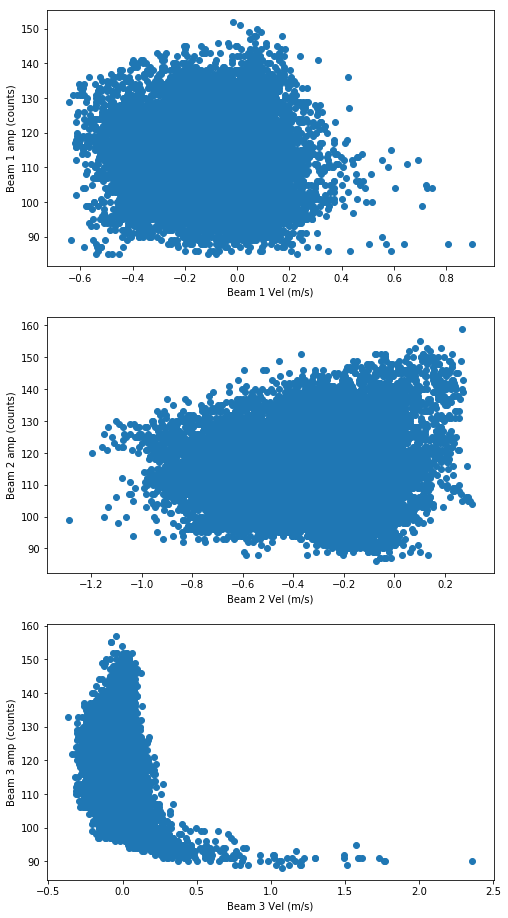

In [57]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=False,figsize=(8,16))
ax1.scatter(velocity_beam1/1000.,ampB1_1m)
ax1.set_ylabel('Beam 1 amp (counts)')
ax1.set_xlabel('Beam 1 Vel (m/s)')

ax2.scatter(velocity_beam2/1000.,ampB2_1m)
ax2.set_ylabel('Beam 2 amp (counts)')
ax2.set_xlabel('Beam 2 Vel (m/s)')

ax3.scatter(velocity_beam3/1000.,ampB3_1m)
ax3.set_ylabel('Beam 3 amp (counts)')
ax3.set_xlabel('Beam 3 Vel (m/s)')

### Examine the velocity with wind and wave data

Text(0,0.5,'Sig wave height (m)')

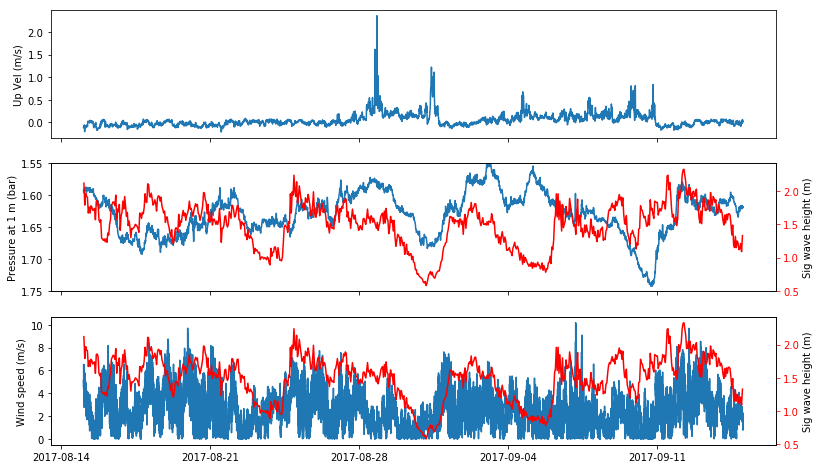

In [30]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True,figsize=(13,8))
ax1.plot(time_vel_1m, up_vel_1m)
ax1.set_ylabel('Up Vel (m/s)')

ax2.plot(time_vel_1m, pressure_1m)
ax2.set_ylabel('Pressure at 1 m (bar)')
ax2.set_ylim((1.75,1.55))
ax22 = ax2.twinx()
ax22.tick_params('y', colors='r')
ax22.plot(time_wave, wave_height,'r')
ax22.set_ylabel('Sig wave height (m)')


ax33 = ax3.twinx()
ax33.tick_params('y', colors='r')
ax3.plot(time_met, wind)
ax33.plot(time_wave, wave_height,'r')
ax3.set_ylabel('Wind speed (m/s)')
ax33.set_ylabel('Sig wave height (m)')


The wave height and wind speed data look normal, and there is no significiant environmental event occuring at the time when velocity spikes were found.  

### Examine pitch, roll, and heading 

Text(0.5,0.98,'Velocity sensor at 1m')

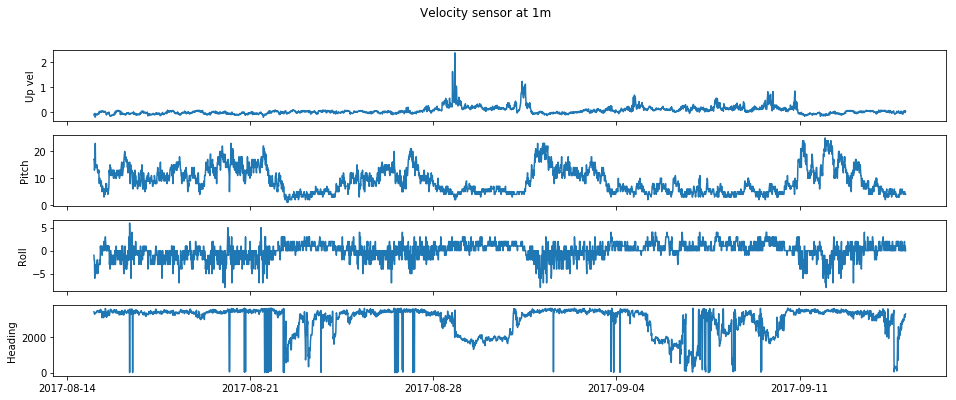

In [31]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex = True, figsize = (16,6))
ax1.plot(time_vel_1m,up_vel_1m)
ax1.set_ylabel('Up vel')
ax2.plot(time_vel_1m,pitch_1m)
ax2.set_ylabel('Pitch')
ax3.plot(time_vel_1m,roll_1m)
ax3.set_ylabel('Roll')
ax4.plot(time_vel_1m,heading_1m)
ax4.set_ylabel('Heading')
plt.suptitle('Velocity sensor at 1m')

### Examine the velocity data (same instrument) at 7 m

Text(0.5,0.98,'Velocity sensor at 7m')

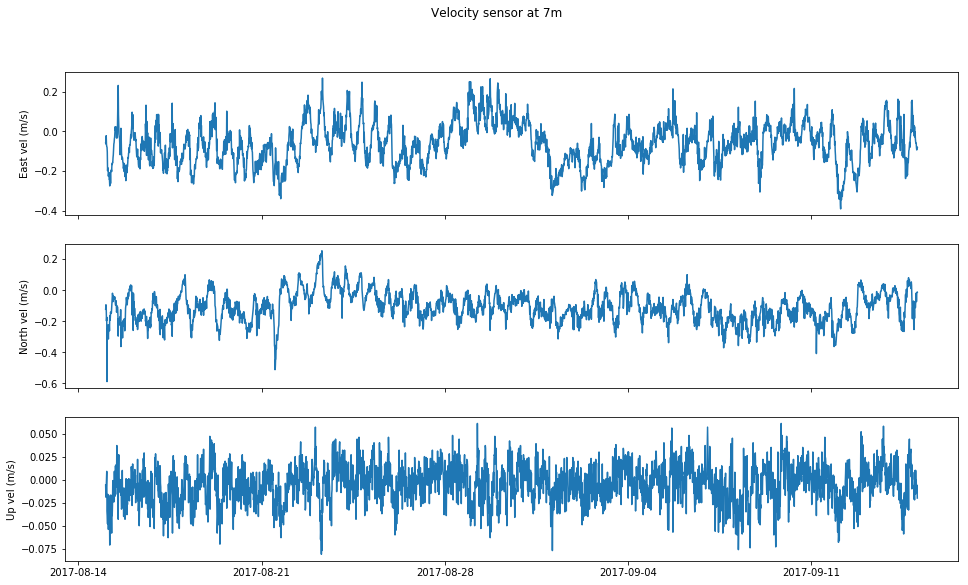

In [32]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex = True, figsize = (16,9))
ax1.plot(time_vel_7m,east_vel_7m)
ax2.plot(time_vel_7m,north_vel_7m)
ax3.plot(time_vel_7m,up_vel_7m)
ax1.set_ylabel('East vel (m/s)')
ax2.set_ylabel('North vel (m/s)')
ax3.set_ylabel('Up vel (m/s)')
plt.suptitle('Velocity sensor at 7m')

The velocity data is reasonable for this sensor at 7 m. The next step is checking the beam amplitude.

Text(0,0.5,'Beam 3 vel (m/s)')

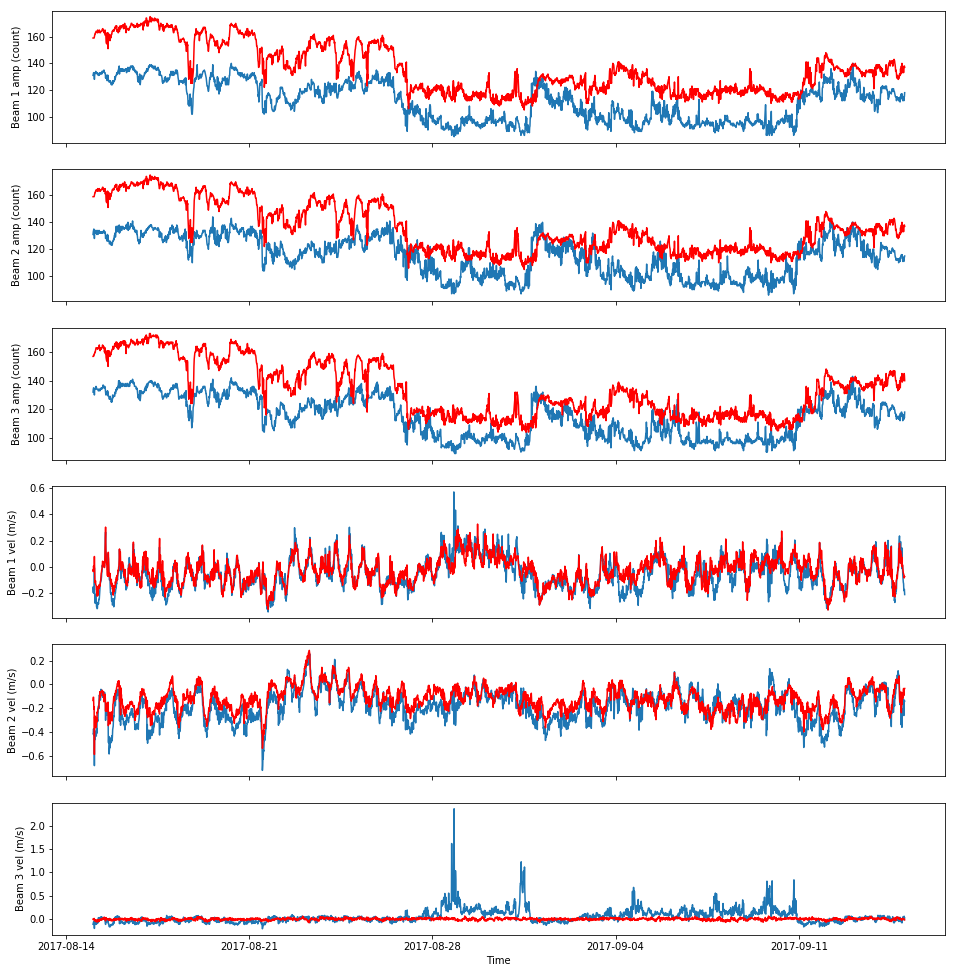

In [33]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(6,1, sharex=True,figsize=(16,17))
ax1.plot(time_vel_1m,ampB1_1m,label='1m')
ax1.plot(time_vel_7m,ampB1_7m,'r')
ax2.plot(time_vel_1m,ampB2_1m)
ax2.plot(time_vel_7m,ampB1_7m,'r')
ax3.plot(time_vel_1m,ampB3_1m)
ax3.plot(time_vel_7m,ampB3_7m,'r')
ax4.plot(time_vel_1m,velocity_beam1/1000.)
ax4.plot(time_vel_7m,velocity_beam1_7m/1000.,'r')
ax5.plot(time_vel_1m,velocity_beam2/1000.)
ax5.plot(time_vel_7m,velocity_beam2_7m/1000.,'r')
ax6.plot(time_vel_1m,velocity_beam3/1000.)
ax6.plot(time_vel_7m,velocity_beam3_7m/1000.,'r')
plt.xlabel('Time')
ax1.set_ylabel('Beam 1 amp (count)')
ax2.set_ylabel('Beam 2 amp (count)')
ax3.set_ylabel('Beam 3 amp (count)')
ax4.set_ylabel('Beam 1 vel (m/s)')
ax5.set_ylabel('Beam 2 vel (m/s)')
ax6.set_ylabel('Beam 3 vel (m/s)')

The beam amplitude of sensor at 7 m is higher than that of sensor at 1 m.

Text(0,0.5,'Temp at 7 m')

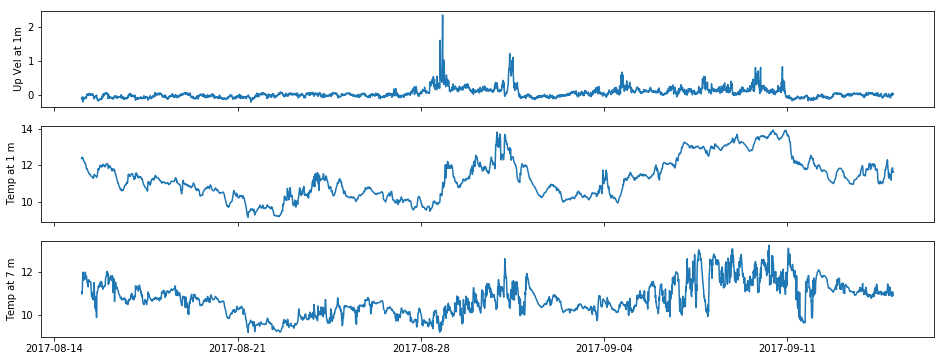

In [34]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1, sharex = True, figsize = (16,6))
ax1.plot(time_vel_1m,up_vel_1m)
ax2.plot(time_vel_1m,temp_1m)
ax3.plot(time_vel_1m,temp_7m)
ax1.set_ylabel('Up Vel at 1m')
ax2.set_ylabel('Temp at 1 m')
ax3.set_ylabel('Temp at 7 m')

Temperature data are similar for both sensors. 
plot the differece of recorded pressure from two velocity sensors, and compare it with the wave height.

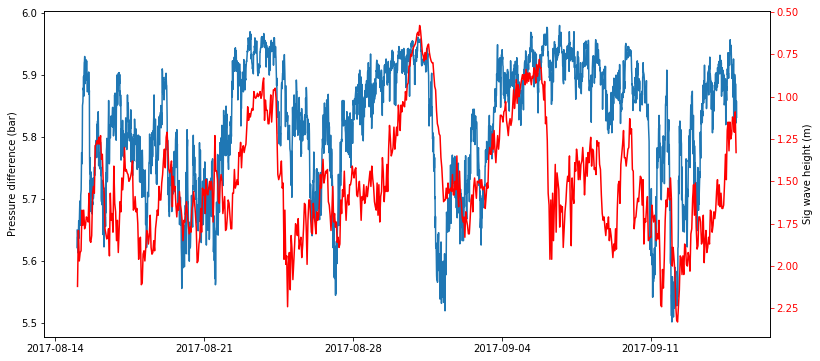

In [35]:
press_diff = pressure_7m - pressure_1m
fig, (ax1) = plt.subplots(1,1, sharex = True, figsize = (13,6))
ax1.plot(time_vel_1m,press_diff)
ax1.set_ylabel('Pressure difference (bar)')
ax2 = ax1.twinx()
ax2.tick_params('y', colors='r')
ax2.set_ylabel('Sig wave height (m)')
ax2.plot(time_wave,wave_height,'r')
ax2.invert_yaxis()

Plot the correlation between two sensors.

Text(0,0.5,'Up vel 7 m')

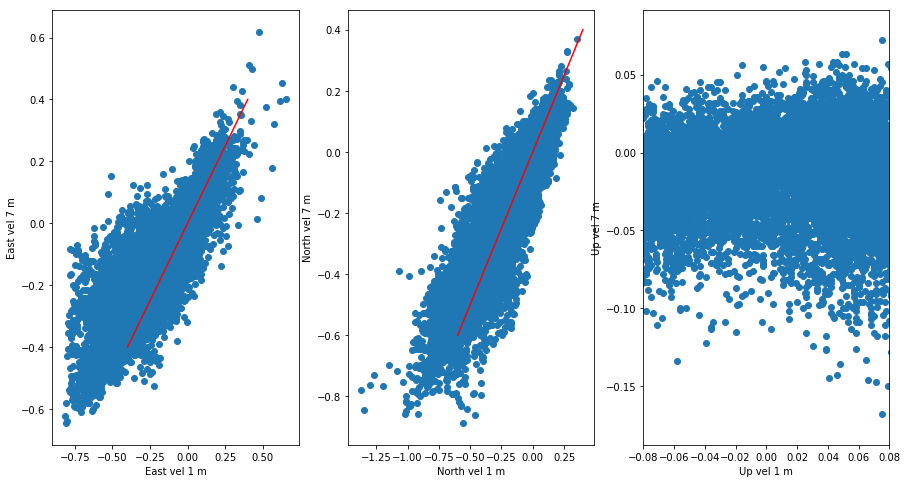

In [41]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,8))
ax1.scatter(east_vel_1m, east_vel_7m)
ax1.set_xlabel('East vel 1 m')
ax1.set_ylabel('East vel 7 m')
ax1.plot([-0.4, 0.4],[-0.4,0.4],'r')
ax2.scatter(north_vel_1m, north_vel_7m)
ax2.plot([-0.6, 0.4],[-0.6,0.4],'r')
ax2.set_xlabel('North vel 1 m')
ax2.set_ylabel('North vel 7 m')
ax3.scatter(up_vel_1m, up_vel_7m)
ax3.set_xlim([-0.08, 0.08])
ax3.set_xlabel('Up vel 1 m')
ax3.set_ylabel('Up vel 7 m')

Text(0.5,0,'Time')

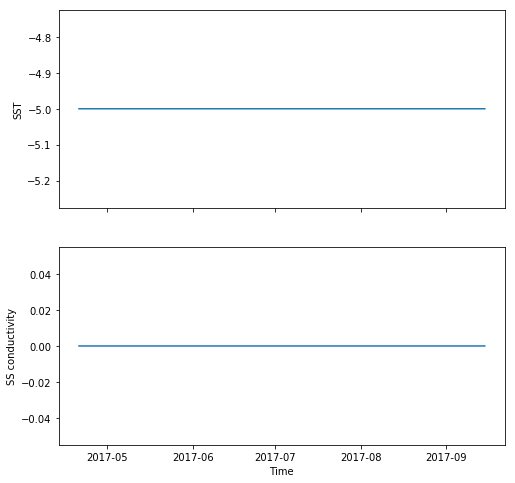

In [65]:
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True, figsize=(8,8))
ax1.plot(time_met,sst)
ax1.set_ylabel('SST')

ax2.plot(time_met,ssc)
ax2.set_ylabel('SS conductivity')
plt.xlabel('Time')

### Look at the data for a longer period 

In [ ]:
# Looking at multiple instruments on the buoy
instruments = [
  ['CE02SHSM','SBD11','04-VELPTA000','recovered_inst','velpt_ab_instrument_recovered'],
  ['CE02SHSM','RID26','04-VELPTA000','recovered_inst','velpt_ab_instrument_recovered'],
  ['CE02SHSM','SBD12','05-WAVSSA000','recovered_host','wavss_a_dcl_statistics_recovered'],
  ['CE02SHSM','SBD11','06-METBKA000','recovered_host','metbk_a_dcl_instrument_recovered']
]
# Specify additional parameters for the API request 
params = {
  'beginDT':'2016-09-15T01:00:00.000Z', 
  'endDT':'2017-09-15T01:00:00.000Z'  
}
# Grab the data for each instrument
out = []
for jj in range(len(instruments)):
  print(jj)
  print instruments[jj]  
  data_request_url ='/'.join((base_url,instruments[jj][0],instruments[jj][1],instruments[jj][2],instruments[jj][3],instruments[jj][4]))
  r = requests.get(data_request_url, params=params, auth=(username, token))
  data = r.json()
  out.append(data['allURLs'][0])

In [ ]:
out

In [37]:
files = [
    'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/bwang314@tamu.edu/20180525T105419-CE02SHSM-SBD11-04-VELPTA000-recovered_inst-velpt_ab_instrument_recovered/deployment0005_CE02SHSM-SBD11-04-VELPTA000-recovered_inst-velpt_ab_instrument_recovered_20170420T173000-20170915T010000.nc',
    'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/bwang314@tamu.edu/20180525T105426-CE02SHSM-RID26-04-VELPTA000-recovered_inst-velpt_ab_instrument_recovered/deployment0005_CE02SHSM-RID26-04-VELPTA000-recovered_inst-velpt_ab_instrument_recovered_20170420T173000-20170915T010000.nc',
    'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/bwang314@tamu.edu/20180525T105431-CE02SHSM-SBD12-05-WAVSSA000-recovered_host-wavss_a_dcl_statistics_recovered/deployment0005_CE02SHSM-SBD12-05-WAVSSA000-recovered_host-wavss_a_dcl_statistics_recovered_20170420T182302.158000-20170915T002303.057000.nc',
    'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/bwang314@tamu.edu/20180525T105440-CE02SHSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0005_CE02SHSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered_20170420T173148.775000-20170915T005911.468000.nc'
    ]

In [38]:
# single point velocity meter at 1 m
d1 = xr.open_dataset(files[0])
time_vel_1m = d1['time'].values
pressure_1m = d1['pressure_mbar'].values/1000.
east_vel_1m = d1['eastward_velocity'].values
north_vel_1m = d1['northward_velocity'].values
up_vel_1m = d1['upward_velocity'].values
heading_1m = d1['heading_decidegree'].values
pitch_1m = d1['pitch_decidegree'].values
roll_1m = d1['roll_decidegree'].values
temp_1m = d1['temperature_centidegree'].values/100.
ampB1_1m = d1['amplitude_beam1'].values
ampB2_1m = d1['amplitude_beam2'].values
ampB3_1m = d1['amplitude_beam3'].values
velocity_beam1 = d1['velocity_beam1'].values
velocity_beam2 = d1['velocity_beam2'].values
velocity_beam3 = d1['velocity_beam3'].values

# single point velocity meter at 7 m
d2 = xr.open_dataset(files[1])
time_vel_7m = d2['time'].values
pressure_7m = d2['pressure_mbar'].values/1000.
east_vel_7m = d2['eastward_velocity'].values
north_vel_7m = d2['northward_velocity'].values
up_vel_7m = d2['upward_velocity'].values
heading_7m = d2['heading_decidegree'].values
pitch_7m = d2['pitch_decidegree'].values
roll_7m = d2['roll_decidegree'].values
temp_7m = d2['temperature_centidegree'].values/100.
ampB1_7m = d2['amplitude_beam1'].values
ampB2_7m = d2['amplitude_beam2'].values
ampB3_7m = d2['amplitude_beam3'].values
velocity_beam1_7m = d2['velocity_beam1'].values
velocity_beam2_7m = d2['velocity_beam2'].values
velocity_beam3_7m = d2['velocity_beam3'].values

# wave statistics at recorded on the buoy
d3 = xr.open_dataset(files[2])
time_wave = d3['time'].values
wave_height = d3['significant_wave_height'].values

# Met data on the buoy
d4 = xr.open_dataset(files[3])
time_met = d4['time'].values
air_temp = d4['air_temperature'].values
sst = d4['sea_surface_temperature'].values
ssc = d4['sea_surface_conductivity'].values
precip = d4['precipitation'].values
wind_e = d4['eastward_wind_velocity'].values
wind_n = d4['eastward_wind_velocity'].values
wind = np.sqrt(wind_e * wind_e + wind_n * wind_n)
heatflux = d4['met_heatflx_minute'].values
latnflux = d4['met_latnflx_minute'].values
sensflux = d4['met_sensflx_minute'].values
  

In [39]:
import scipy

from scipy import signal

wind_smooth=signal.savgol_filter(wind, 1153, 3)

Text(0,0.5,'Air temp')

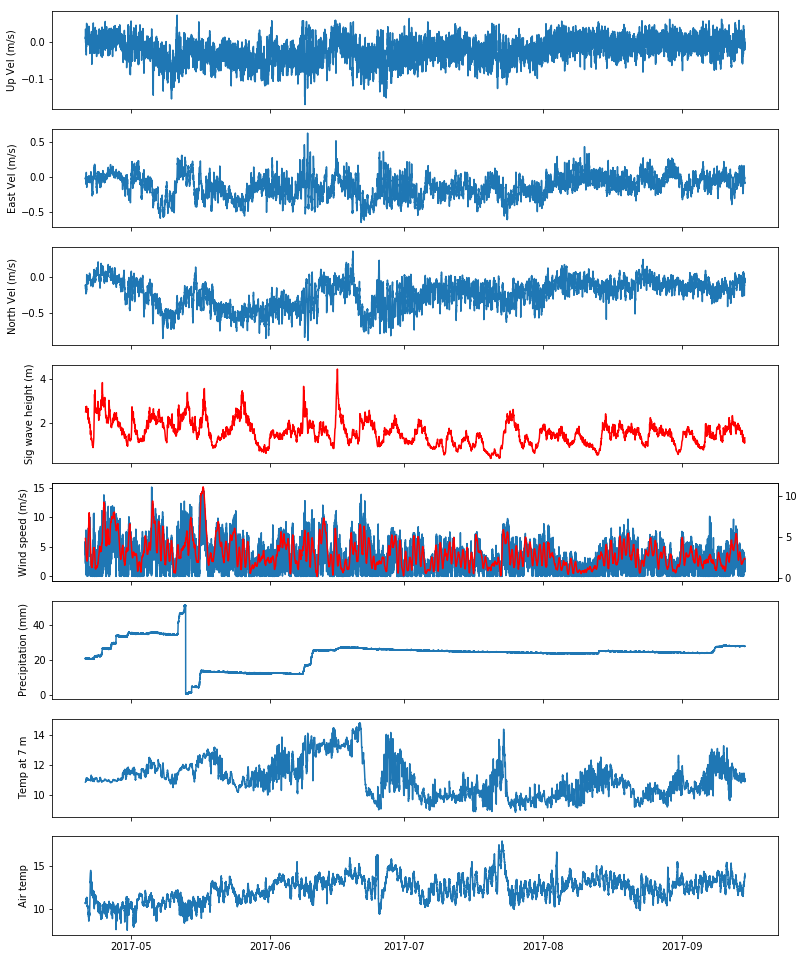

In [40]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(8,1, sharex=True,figsize=(13,17))
ax1.plot(time_vel_7m, up_vel_7m)
ax1.set_ylabel('Up Vel (m/s)')

ax2.plot(time_vel_7m, east_vel_7m)
ax2.set_ylabel('East Vel (m/s)')

ax3.plot(time_vel_7m, north_vel_7m)
ax3.set_ylabel('North Vel (m/s)')

ax4.plot(time_wave, wave_height,'r')
ax4.set_ylabel('Sig wave height (m)')

ax5.plot(time_met, wind)
ax5.set_ylabel('Wind speed (m/s)')
ax55 = ax5.twinx()
ax55.plot(time_met,wind_smooth,'r')

ax6.plot(time_met,precip)
ax6.set_ylabel('Precipitation (mm)')

ax7.plot(time_vel_7m,temp_7m)
ax7.set_ylabel('Temp at 7 m')

ax8.plot(time_met, air_temp)
ax8.set_ylabel('Air temp')

The precipitation data is hard to understand, from early June 2017, precipitation data show around 25 mm all the time. Not sure how precipitation data was recorded and calculated. 

There are two notable decreasing water temperature events during mid-late June and late July in 2017. In the first event, there was also increasing water velocity in the southwest direction and vetical direction.This might be a upwelling event. In the second event, the water temperature falling seems to be the response to the air temperature decrease. No signifciant upwelling velocity was observed. Futher investigation is needed to examine these two events. 

## Conclusion
Based on this short analysis, several take aways are noted:

In general, the velocity sensors have good performance in terms of capturing motion of water. Some issues were found. There issues need to be further investigated:

1. It seems that velocity measurements at 1 m show spikes when the beam amplitude drop to a certain value. The Beam 3 is very sensitive to this, showing spikes in signal. 

2. Velocity meter at 7 m performed well without issues. The horizontal components align well with those in the 1 m velocity measurements. The velocities are also correlated with the sea state.

3. The potential error in water velocity affects the calculation of the relative wind speed. 

4. Precipitation is hard to understand, further examination is needed.

5. Some notable temperature drops occur in this measurement period. The decreasing temperature may be associated with different environmental evetns. further investigation is needed. 